# Introduction

This task is on using linear blend skinning to deform a shape based on a given skeleton. You will be able to change the joint rotations and visualize the resulting deformation. The function you need to complete is marked with "TO IMPLEMENT".

**Initialisation Scripts**

We are providing the framework below that handles visualisation, sliders, and the skeleton data structure (as noted in the lecture, the choice to store transformations on bones or joints is arbitrary and here we will use joints). These are under "Initialisation Scripts" below. Please run the code cells there only once before you move on. 

Note that you will need to **run each code cell in order and only once for the same runtime**. We divided the code into multiple cells for convenience. It might take a while until all is installed for the code cell "Install Packages - Run Once".

**Rigid Body Skinning Example**

We then show an example to illustrate how to use the framework with rigid body skinning, i.e. no blending of transformations is happening for that case and each vertex is attached to only one joint. Please run and examine especially the implementation of the function def rigid_skinning(vertices, skeleton) to understand how you

* compute the joint transformations,
* apply them to each vertex with given weights,
* return the resulting vertex locations.

You can play with the sliders to see the deformed mesh (please wait a couple of seconds after you update the sliders to see the shape updated). As you will see, we have cracks or discontinuities in the resulting shape. This is because we do not blend transformations. The weight per-vertex is visualized on the object as well.

**Task 2: Linear Blend Skinning**

You can then move on to the actual exercise, where you need to fill in the function to use linear blend skinning to transfer skeletal transformations to the object. Please see the instructions at the beginning of the cell.

You should be able to obtain images similar to the following reference images.

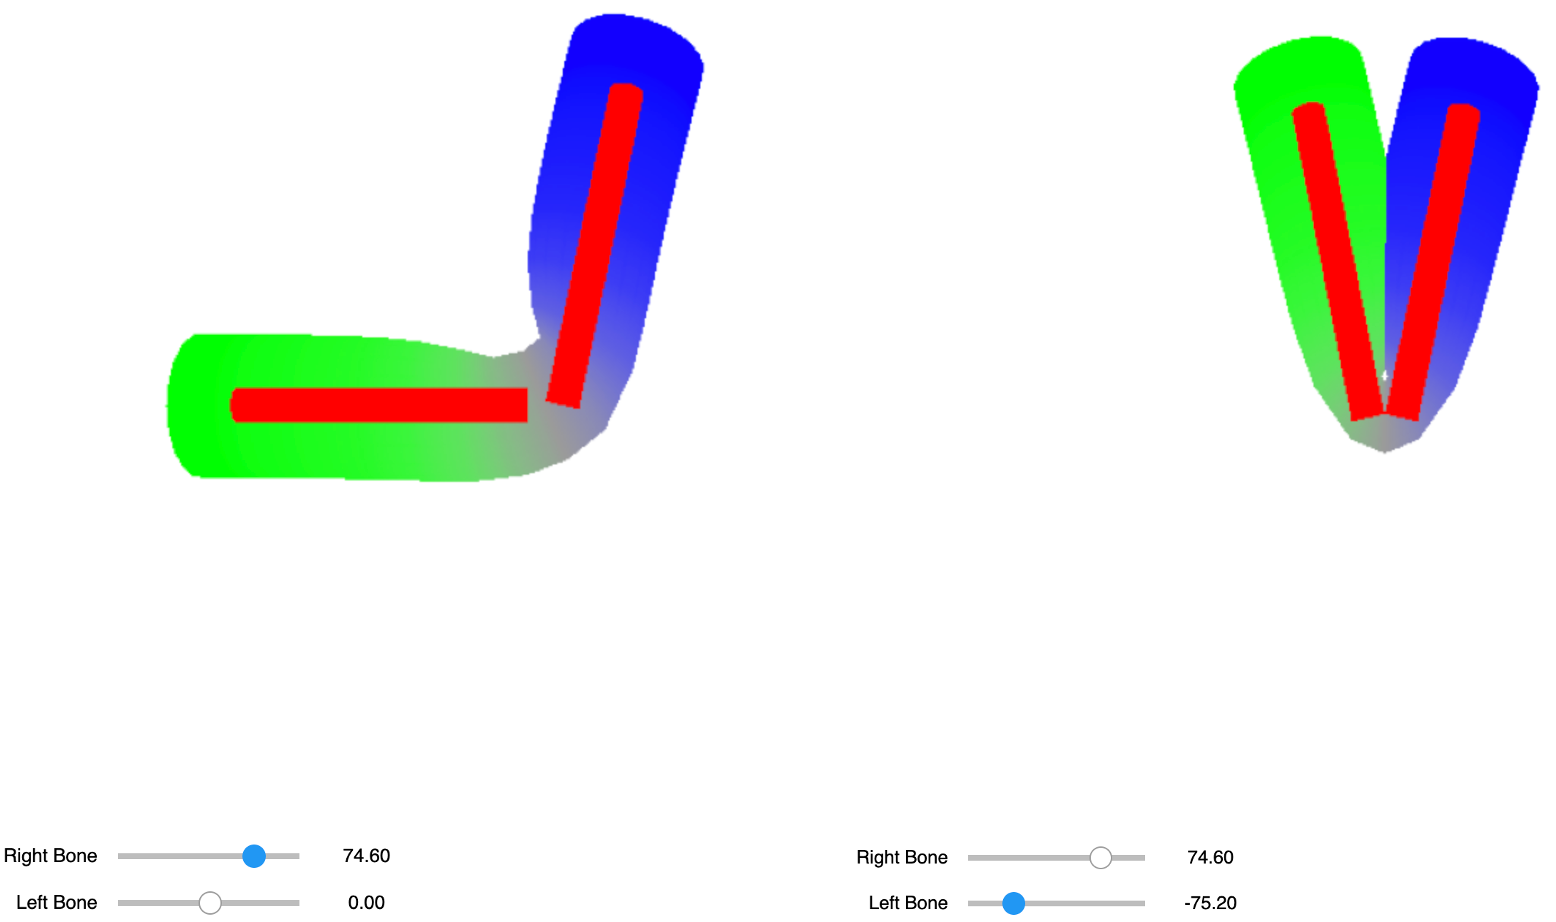

# Initialisation Scripts

Please run these code cells once in the beginning of the session.

In [1]:
"""


Clear Current Working Directory - Run Once


"""
!rm -rf ./*

In [2]:
"""


Install Packages - Run Once


"""
!sudo apt update
!sudo wget https://github.com/mmatl/travis_debs/raw/master/xenial/mesa_18.3.3-0.deb
!sudo dpkg -i ./mesa_18.3.3-0.deb || true
!sudo apt install -f
!git clone https://github.com/mmatl/pyopengl.git
!pip3 install ./pyopengl
!pip3 install ipywidgets
!pip3 install pyrender
!pip3 install trimesh


Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,400 kB]
Hit:12 http://ppa.launchpad.net/cra

In [3]:
"""


Framework - Run Once


"""

import os
os.environ["PYOPENGL_PLATFORM"] = "osmesa"
import numpy as np
import matplotlib.pyplot as plt
import pyrender
import trimesh
import scipy
import copy


import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import display,clear_output


class Joint:

  def __init__(self, translation, rotation, parent=None):

    self.translation = translation
    self.rotation = rotation
    self.parent = parent
    
  def get_world_translation(self):

    if self.parent:
      return self.parent.get_world_translation() + self.translation
    else:
      return self.translation 


class Skeleton:

  def __init__(self, joints, hierarchy):
      self.joints = joints
      self.rest_joints = copy.deepcopy(joints)
      self.hierarchy = hierarchy


def get_rigid_body_weights(vertices=None, skeleton=None):
  return rigid_body_weights

weighting_func = get_rigid_body_weights


def no_skinning(vertices, skeleton):
  return vertices[:, 0:3]

skinning_func = no_skinning


def render_scene():
    global mesh_node

    vertices = skinning_func(np.concatenate([trimesh_box.vertices, np.ones([trimesh_box.vertices.shape[0], 1])], axis=1), skeleton)
    faces = trimesh_box.faces
    weights = weighting_func(trimesh_box.vertices, skeleton)
    trimesh_mesh = trimesh.Trimesh(vertices=vertices, faces=faces, vertex_colors=255 * weights[:, 0:3])
    mesh = pyrender.Mesh.from_trimesh(trimesh_mesh)
    mesh.baseColorFactor=[1.0, 1.0, 1.0, 1.0]
    mesh_node = scene.add(mesh, pose=mesh_pose)
    colour, depth = viewer.render(scene, flags=0)
    scene.remove_node(mesh_node)

    joint_mesh_nodes = []
    for joint in skeleton.joints:
      if joint.parent:
        joint_start = joint.parent.get_world_translation() + 0.05 * joint.translation
        rotation = scipy.spatial.transform.Rotation.from_euler('xyz', joint.rotation)
        joint_end = np.matmul(rotation.as_matrix(), joint.translation)[0:3]
        joint_trimesh = trimesh.creation.cylinder(radius=0.5, segment=[joint_start, 0.9 * joint_end])
        joint_mesh = pyrender.Mesh.from_trimesh(joint_trimesh)
        joint_mesh_node = scene.add(joint_mesh, pose=mesh_pose, parent_name=None)
        joint_mesh_nodes.append(joint_mesh_node)

    colour_joints, depth = viewer.render(scene, flags=0)
    colour_joints = (255 - colour_joints) * 1000
    colour_joints = colour_joints * np.array([1, 0, 0])
    frame = np.maximum(colour, colour_joints)
    frame[frame[:, :, 0] > 255] = np.array([255, 0, 0])
    frame = np.clip(frame, a_min=0, a_max=255)

    for joint_mesh_node in joint_mesh_nodes:
      scene.remove_node(joint_mesh_node)

    ax.clear()
    plt.axis('off')
    ax.imshow(frame)
    with out:
        clear_output(wait=True)
        display(ax.figure)


def handle_r_change(change):
    global trimesh_box
    global posed_vertices 
    global joint_2

    trimesh_box.vertices = posed_vertices
    skeleton.joints[2].rotation[2] = (np.pi / 180.0) * change.new
    render_scene()


def handle_l_change(change):
    global trimesh_box
    global posed_vertices
    global joint_2

    trimesh_box.vertices = posed_vertices
    skeleton.joints[1].rotation[2] = (np.pi / 180.0) * change.new
    render_scene()


def init_framework():
    global ax
    global fig
    global out
    global r_slider_widget
    global l_slider_widget
    global viewer
    global cam
    global trimesh_box
    global mesh
    global scene
    global rigid_body_weights
    global skeleton
    global mesh_node
    global posed_vertices
    global mesh_pose
  
    plt.ioff()
    plt.axis('off')
    ax = plt.gca()
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)

    out = widgets.Output(layout=Layout(height='600', width = '800'))
    r_slider_widget = widgets.FloatSlider(description='Right Bone', min=-150, max=150, value=0)
    l_slider_widget = widgets.FloatSlider(description='Left Bone', min=-150, max=150, value=0)

    viewer = pyrender.OffscreenRenderer(viewport_width=640, viewport_height=480, point_size=1.0)
    cam = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1.414)
    trimesh_box = trimesh.creation.cylinder(radius=2, segment=[[-10, 0, 0], [10, 0, 0]], sections=20)
    trimesh_box.vertices, trimesh_box.faces = trimesh.remesh.subdivide_to_size(trimesh_box.vertices, trimesh_box.faces, 2, max_iter=5)
    mesh = pyrender.Mesh.from_trimesh(trimesh_box)
    scene = pyrender.Scene(ambient_light=[1.0, 1.0, 1.0], bg_color=[1.0, 1.0, 1.0])

    mesh_pose = np.array([
                         [1, 0, 0, 0],
                         [0, 1, 0, 0],
                         [0, 0, 1, -20.0],
                         [0, 0, 0, 1]
    ])

    scene.add(cam, pose=np.eye(4))
    rest_vertices = trimesh_box.vertices
    posed_vertices = rest_vertices

    root_joint = Joint(np.array([0.0, 0.0, 0.0]), np.array([0.0, 0.0, 0.0]))
    joint_1 = Joint(np.array([-10.0, 0.0, 0.0]), np.array([0.0, 0.0, 0.0]), root_joint)
    joint_2 = Joint(np.array([10.0, 0.0, 0.0]), np.array([0.0, 0.0, 0.0]), root_joint)
    skeleton = Skeleton([root_joint, joint_1, joint_2], [[0, -1], [1, 0], [2, 0]])
    rigid_body_weights = np.array([[0, 1, 0] if v[0] < 0 else [0, 0, 1] for v in rest_vertices])


def display_ui(sf=None, wf=None):
    global skinning_func
    global weighting_func

    if sf:
      skinning_func = sf
    if wf:
      weighting_func = wf

    vbox = widgets.VBox(children=(out, r_slider_widget, l_slider_widget))
    display(vbox)
    r_slider_widget.observe(handle_r_change, names='value')
    l_slider_widget.observe(handle_l_change, names='value')
    render_scene()


print('OK')


OK


# Rigid Body Skinning Example

In [4]:
"""

This example shows how you will use the joint transformations and the
skinning weights to compute the final positions of vertices. Please scroll
to the function def rigid_skinning(vertices, skeleton) below to see how 
these are done.

"""


import scipy


def get_local_matrix(joint):
  def M(axis, theta):
    return scipy.linalg.expm(np.cross(np.eye(3), axis / scipy.linalg.norm(axis) * theta))

  rotation = np.matmul(
      M(np.array([1, 0, 0]), joint.rotation[0]), 
      np.matmul(
          M(np.array([0, 1, 0]), joint.rotation[1]),
          M(np.array([0, 0, 1]), joint.rotation[2]))
      )
  result = np.zeros([4, 4])
  result[0:3, 0:3] = rotation
  result[0:3, 3] = joint.translation
  result[3, 3] = 1

  return result


def get_world_matrix(joint):
  if joint.parent:
    return np.matmul(get_world_matrix(joint.parent), get_local_matrix(joint))
  else:
    return get_local_matrix(joint)


def get_bind_matrix(joint):
  return np.linalg.inv(get_world_matrix(joint))


def rigid_skinning(vertices, skeleton):
  """

  Please read this function in detail. You will see how we compute the joint
  transformation matrices as a composition of two matrices given by the 
  get_bind_matrix and get_world_matrix functions for each joint. Then you will
  see how we apply this composition to each vertex (without blending for this
  case).
  
  """

  #Compute the joint transformation matrices
  joint_matrices = []
  for i in range(0, len(skeleton.joints)):
    joint_matrices.append(np.matmul(get_bind_matrix(skeleton.rest_joints[i]), get_world_matrix(skeleton.joints[i])))
  print("joint_matrices")
  print(joint_matrices)
  #Compute the rigid body weights: for each vertex we have three weights for 
  #three joints. Only one is non-zero, the rest are zero, i.e.
  #weights = np.array([[0, 1, 0] if v[0] < 0 else [0, 0, 1] for v in rest_vertices])
  #Hence, all vertices with v[0] < 0 are only affected by joint 1 and the rest 
  #are only affected by joint 2.
  weights = get_rigid_body_weights()
  print("weights")
  print(len(weights))
  print(joint_matrices[np.argmax(weights[2])])
  print(len(vertices))
  print(np.matmul(joint_matrices[np.argmax(weights[2])], vertices[2]))
  #Apply the joint matrices without blending to the vertices
  result = np.array([np.matmul(joint_matrices[np.argmax(weights[i])], vertices[i]) for i in range(0, vertices.shape[0])])

  #Return the first three components of the vertices that define the 3D position
  return result[:, 0:3]


init_framework()
display_ui(rigid_skinning, get_rigid_body_weights)

joint_matrices
[array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])]
weights
5482
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
5482
[-1.0000000e+01  2.4492936e-16  2.0000000e+00  1.0000000e+00]


# Linear Blend Skinning

In [5]:
"""

Task 2 - Linear Blend Skinning

We provide the functions to compute the weights, which are based on a simple
rule: distance of the location of each vertex to the line segment defined
by the joint locations. We ask you to complete the function 
def linear_blend_skinning(vertices, skeleton).

"""


def compute_distance_to_line_segment(x, line_seg):
  x = x[0:3]
  p1 = line_seg[0]
  p2 = line_seg[1]
  d = p2 - p1
  t = np.dot(x - p1, p2 - p1) / (np.linalg.norm(p2 - p1 + 0.00001) ** 2)
  t = min(max(t, 0.0), 1.0)

  return np.linalg.norm(x - (p1 + (t * d))) + 0.00001


def compute_linear_blend_weights(vertices, skeleton):
  def get_joint_line_seg(joint):
    if joint.parent:
      return np.array([joint.parent.get_world_translation(), joint.get_world_translation()])
    else:
      return np.array([joint.get_world_translation(), joint.get_world_translation()])
  
  joint_line_segments = np.array([get_joint_line_seg(joint) for joint in skeleton.joints])
  weights = np.array([[1.0 / (compute_distance_to_line_segment(vertices[i], joint_line_segments[j]) ** 4.0) 
                      for j in range(0, joint_line_segments.shape[0])] 
                      for i in range(0, vertices.shape[0])])
  weights = weights / weights.sum(axis=1)[:, None]

  return weights


def linear_blend_skinning(vertices, skeleton):
  """

  TO IMPLEMENT

  Arguments:
    vertices: It stores the location of vertices such that vertices[i] is
    the location of vertex i in homogenous coordinates.
    skeleton: It stores the skeleton data structure. 

  Returns:
    The new 3D positions of vertices.
  
  Please see the function def rigid_skinning(vertices, skeleton) above to 
  understand how this data structure is used to get joint transformations and 
  how the transformations are applied to the vertices.
  
  """

  #weights[i, j] store the weights for the vertex i and joint j
  weights = compute_linear_blend_weights(vertices, skeleton)

  #Get joint transformations, similar to the rigid body skinning case
  joint_matrices = []
  for i in range(0, len(skeleton.joints)):
    joint_matrices.append(np.matmul(get_bind_matrix(skeleton.rest_joints[i]), get_world_matrix(skeleton.joints[i])))

  #Blend joint transformations to get vertex_matrices
  vertex_matrices = [np.sum([weights[i][j] * joint_matrices[j] for j in range(0, weights[i].shape[0])], axis=0) for i in range(0, vertices.shape[0])]
  
  #Apply vertex_matrices to the vertices to compute the new vertex locations
  vertices = np.array([np.matmul(vertex_matrices[i], vertices[i]) for i in range(0, vertices.shape[0])])

  #Return the first three components of vertices, i.e. the 3D locations
  return vertices[:, 0:3]


"""

Don't Touch

"""
init_framework()
display_ui(linear_blend_skinning, compute_linear_blend_weights)